In [ ]:
## cross sections normalised - code from Taimoor Sohail

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
#JRA_data = xr.open_mfdataset('/g/data/e14/txs156/Data/Observations/JRA/JRA_ACCESS/JRA_ACCESS_fluxes_combi.nc')
from dask.distributed import Client,LocalCluster


In [3]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43843/status,
Dashboard: /proxy/43843/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39163,Workers: 2
Dashboard: /proxy/43843/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:36687,Total threads: 1
Dashboard: /proxy/38305/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44223,


In [4]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '02:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )


# and if you want even more power, you can use this to make it three nodes

cluster.scale(jobs=1)


# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/34077/status,
Dashboard: /proxy/34077/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.35:43473,Workers: 0
Dashboard: /proxy/34077/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [6]:
lat_slice = slice(-80, -59)
#start_time, end_time = '2110-01-31', '2159-12-31'
start_time='2150-01-01 00:00:00'
end_time='2159-12-31 00:00:00'

# Import bathymetry - t-grid
ht = cc.querying.getvar(expt, 'ht', session, n=1)
ht = ht.sel(yt_ocean=lat_slice)
# Import bathymetry - u-grid
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)

expt = '01deg_jra55v13_ryf9091_qian_wthmp'
#exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'

# Import properties to average
temp = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, attrs={'cell_methods': 'time: mean'}, frequency='1 monthly')#, ncfile="ocean.nc")
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt = cc.querying.getvar(expt, 'salt', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
salt = salt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
density = cc.querying.getvar(expt, 'pot_rho_0', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
density = density.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
u = cc.querying.getvar(expt, 'u', session, start_time=start_time, end_time=end_time, frequency='1 monthly')#, ncfile="ocean.nc")
u = u.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice)



In [7]:
%%time
# thickness / area for depth averaging (not time varying):

xt_ocean = cc.querying.getvar(expt,'xt_ocean' , session,n=1)
yt_ocean = cc.querying.getvar(expt,'yt_ocean' , session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':yt_ocean,'xt_ocean':xt_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_t = cc.querying.getvar(expt,'area_t',session,n=1)
area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t*thickness
volume = volume.load()



CPU times: user 14.4 s, sys: 8 s, total: 22.4 s
Wall time: 25.1 s


In [8]:
%%time
# thickness / area for depth averaging (not time varying):

xu_ocean = cc.querying.getvar(expt,'xu_ocean' , session,n=1)
yu_ocean = cc.querying.getvar(expt,'yu_ocean' , session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_slice)
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':yu_ocean,'xu_ocean':xu_ocean}, axis=[1,2])

st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness_u = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness_u['st_edges_ocean'] = st_ocean.values
thickness_u = thickness_u.rename(({'st_edges_ocean':'st_ocean'}))

# area for area averaging:

area_u = cc.querying.getvar(expt,'area_u',session,n=1)
area_u = area_u.sel(yu_ocean=lat_slice)

volume_u = area_u*thickness_u
volume_u = volume_u.load()


CPU times: user 13.5 s, sys: 8.03 s, total: 21.5 s
Wall time: 23.9 s


## Do any masking prior to binning with $\textit{xhistogram}$

In [ ]:
# We need to define a mask based on the time, longitudes that CSHT is high onto the shelf, vs high off the shelf, AND the 3 regimes identified by the regime mask .

# Load regime mask
regimes xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')

# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

# Define the mask as all depths around Antarctica shallower than 3000m 



In [9]:
import gc
c.run(gc.collect)

{'tcp://10.6.129.32:32895': 483,
 'tcp://10.6.129.32:33795': 481,
 'tcp://10.6.129.32:35119': 345,
 'tcp://10.6.129.32:36473': 799,
 'tcp://10.6.129.32:37023': 705,
 'tcp://10.6.129.32:37065': 335,
 'tcp://10.6.129.32:37707': 376,
 'tcp://10.6.129.32:37785': 452,
 'tcp://10.6.129.32:37807': 438,
 'tcp://10.6.129.32:38283': 548,
 'tcp://10.6.129.32:38903': 250,
 'tcp://10.6.129.32:40095': 444,
 'tcp://10.6.129.32:40869': 558,
 'tcp://10.6.129.32:41189': 541,
 'tcp://10.6.129.32:42353': 377,
 'tcp://10.6.129.32:42989': 629,
 'tcp://10.6.129.32:43213': 511,
 'tcp://10.6.129.32:43901': 593,
 'tcp://10.6.129.32:43987': 362,
 'tcp://10.6.129.32:44167': 533,
 'tcp://10.6.129.32:45161': 434,
 'tcp://10.6.129.32:45171': 842,
 'tcp://10.6.129.32:45183': 588,
 'tcp://10.6.129.32:45445': 417,
 'tcp://10.6.129.32:45491': 592,
 'tcp://10.6.129.32:45813': 330,
 'tcp://10.6.129.32:45879': 363,
 'tcp://10.6.129.32:46029': 419}

In [ ]:
%%time
bins_isobath = st_edges_ocean.values

V_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume)
Vu_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u)

A_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = area_t)
Au_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = area_u)

TV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*temp)
SV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*salt)
rhoV_sum = histogram(ht, bins = bins_isobath, dim = ['yt_ocean', 'xt_ocean'], weights = volume*density)
uV_sum = histogram(hu, bins = bins_isobath, dim = ['yu_ocean', 'xu_ocean'], weights = volume_u*u)

T_mean = TV_sum/V_sum
S_mean = SV_sum/V_sum
rho_mean = rhoV_sum/V_sum
u_mean = uV_sum/Vu_sum

T_mean.load()
'''
rho_mean.load()
S_mean.load()
u_mean.load()
'''

In [ ]:
rho_mean.load()
S_mean.load()
u_mean.load()

In [ ]:
normalised_area_cumsum = A_sum.cumsum('ht_bin')/np.nansum(A_sum)
normalised_area_cumsum_u = Au_sum.cumsum('hu_bin')/np.nansum(Au_sum)

pseudo_lat = -1*(80-(80-59)*normalised_area_cumsum)
plt.plot(pseudo_lat.values)

In [ ]:
expt

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties exp = ' + expt)
plt.show()

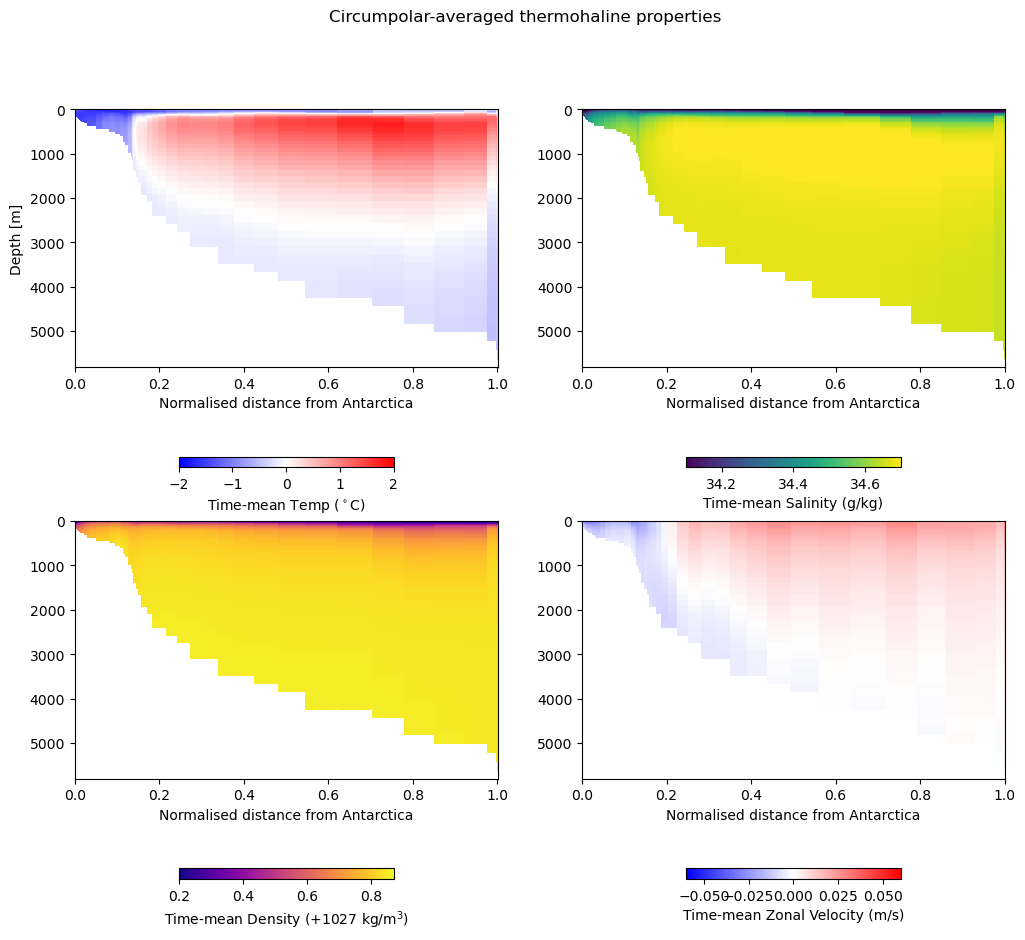

In [16]:
fig, axs = plt.subplots(2,2, figsize=(24*0.5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.15, wspace=0.2)
axs = axs.ravel()


im1 = axs[0].pcolor(normalised_area_cumsum, st_ocean, T_mean.mean('time')-273.15, vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].pcolor(normalised_area_cumsum, st_ocean, S_mean.mean('time'), vmin=34.1, vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].pcolor(normalised_area_cumsum, st_ocean, rho_mean.mean('time')-1027, vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].pcolor(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Normalised distance from Antarctica')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.25, orientation = 'horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.25, orientation = 'horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

plt.suptitle('Circumpolar-averaged thermohaline properties')
plt.show()